In [3]:
from gcp.load_file import GCSLoader
import os
import tempfile

gcs = GCSLoader("raw_avros")
folder = "test"
for blob_name in gcs.list_files():
    gcs.load_to_path(blob_name, os.path.join(folder, blob_name))

2025-01-19 18:32:45,427 - INFO - Initializing GCS Loader
2025-01-19 18:32:45,801 - INFO - GCS Loader initialized


In [5]:
import glob
import numpy as np
import avro.datafile
import avro.io
from schema import SCHEMA

def load_avro_data(schema_dict, data_path):
    # Get list of numeric fields (excluding strings and target variable)
    numeric_fields = [
        field["name"] for field in schema_dict["fields"]
        if field["type"] in ["double", "long"]
        and field["name"] != "flight_time_to_arrival"
    ]

    # Initialize lists to store features and target
    features = []
    targets = []

    # Process each AVRO file in the directory
    for avro_file in glob.glob(data_path):
        with avro.datafile.DataFileReader(open(avro_file, 'rb'), avro.io.DatumReader()) as reader:
            for record in reader:
                # Extract numeric features
                feature_row = [record[field] for field in numeric_fields]
                features.append(feature_row)

                # Extract target variable
                targets.append(record["flight_time_to_arrival"])

    # Convert to numpy arrays
    X = np.array(features)
    y = np.array(targets)

    # Get feature names for reference
    feature_names = numeric_fields

    return X, y, feature_names

In [7]:
# Load the data
data_path = "test/*.avro"#"../data/training_data/*.avro"
X, y, feature_names = load_avro_data(SCHEMA, data_path)

# Print dataset information
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

Features shape: (2147851, 21)
Target shape: (2147851,)

Feature names:
0: timestamp
1: flight_location_latitude
2: flight_location_longitude
3: flight_arrival_airport_location_latitude
4: flight_arrival_airport_location_longitude
5: flight_timestamp
6: flight_horizontal_speed
7: flight_altitude
8: flight_vertical_speed
9: flight_heading
10: flight_distance_to_destination
11: flight_arrival_time
12: weather_timestamp
13: weather_temperature_celsius
14: weather_feels_like_celsius
15: weather_wind_speed_kph
16: weather_humidity_percent
17: weather_precipitation_mm
18: weather_visibility_km
19: weather_pressure_mb
20: weather_uv_index


In [3]:
import json

np.save('X_features.npy', X)
np.save('y_target.npy', y)
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)

In [36]:
import json

X = np.load('X_features.npy')
y = np.load('y_target.npy')
with open('feature_names.json', 'r') as f:
    feature_names = json.load(f)


Analyzing feature importance on sample...

Top 10 correlations with target:
flight_distance_to_destination              0.932942
flight_altitude                             0.450981
flight_horizontal_speed                     0.286410
flight_vertical_speed                       0.169617
flight_arrival_airport_location_latitude    0.077369
flight_location_latitude                    0.073622
weather_feels_like_celsius                  0.063756
weather_temperature_celsius                 0.063033
weather_humidity_percent                    0.032417
timestamp                                   0.018190
dtype: float64

Top 10 Most Important Features (Random Forest):
                                      feature  importance
10             flight_distance_to_destination    0.917208
6                     flight_horizontal_speed    0.037574
7                             flight_altitude    0.005438
2                   flight_location_longitude    0.004252
9                              flight_h

<Figure size 1200x600 with 0 Axes>

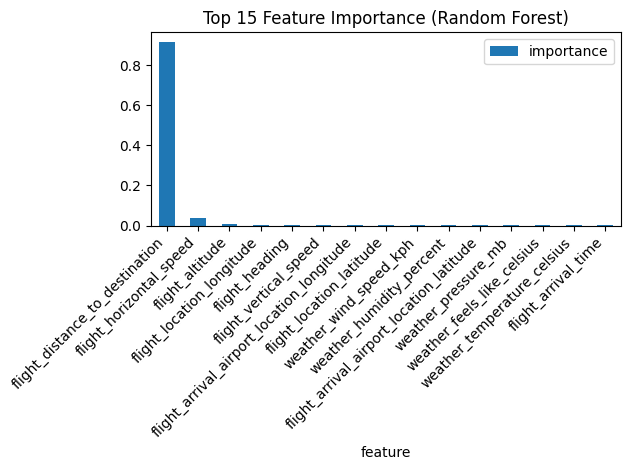


Selected 2 important features with threshold 0.01
Important features: ['flight_distance_to_destination', 'flight_horizontal_speed']

Training final model on full dataset with selected features...
(2147851, 2)

Model Performance:
Test RMSE: 351.88
Test MAE: 219.31
Test R2: 0.9250


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


# Take a smaller sample for initial feature importance analysis
SAMPLE_SIZE = 100000
np.random.seed(42)
sample_indices = np.random.choice(X.shape[0], SAMPLE_SIZE, replace=False)
X_sample = X[sample_indices]
y_sample = y[sample_indices]

print("\nAnalyzing feature importance on sample...")
# Quick correlation analysis
df_sample = pd.DataFrame(X_sample, columns=feature_names)
correlations = df_sample.corrwith(pd.Series(y_sample))
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("\nTop 10 correlations with target:")
print(correlations_sorted.head(10))

# Random Forest on sample for feature importance
rf_sample = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)
rf_sample.fit(X_sample, y_sample)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_sample.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(importance_df.head(10))

# Plot top 15 feature importances
plt.figure(figsize=(12, 6))
importance_df.head(15).plot(x='feature', y='importance', kind='bar')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select top important features (using importance threshold)
IMPORTANCE_THRESHOLD = 0.01  # adjust based on the results
important_features = importance_df[importance_df['importance'] > IMPORTANCE_THRESHOLD]
important_feature_names = important_features['feature'].tolist()

print(f"\nSelected {len(important_feature_names)} important features with threshold {IMPORTANCE_THRESHOLD}")
print("Important features:", important_feature_names)

# Train final model using important features only
print("\nTraining final model on full dataset with selected features...")
X_important = X[:, [feature_names.index(feat) for feat in important_feature_names]]
print(X_important.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train final model
final_rf = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
final_rf.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = final_rf.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2: {r2:.4f}")

In [9]:
[feature_names.index(feat) for feat in important_feature_names]

[10, 6]

In [41]:
# Take a small random sample
np.random.seed(42)
sample_size = 100
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_idx]
y_sample = y_test[sample_idx]

y_pred = final_rf.predict(scaler.transform(X_sample))

results_df = pd.DataFrame({
    "Distance": X_sample[:, 0],
    "Speed": X_sample[:, 1],
    'Actual_Time_to_Arrival': y_sample,
    'Predicted_Time_to_Arrival': y_pred,
    'Absolute_Error': np.abs(y_sample - y_pred)
})
results_df

,Distance,Speed,Actual_Time_to_Arrival,Predicted_Time_to_Arrival,Absolute_Error
0,313.120648,885.082086,2050,1816.051830,233.948170
1,222.125716,211.318340,1229,2666.404618,1437.404618
2,337.180906,811.514997,2355,1975.289269,379.710731
3,62.541903,727.131862,587,626.283989,39.283989
4,354.775747,784.590271,2184,2077.350810,106.649190
...,...,...,...,...,...
95,378.563100,649.307655,1816,2349.054382,533.054382
96,510.194890,797.362457,3099,2737.412309,361.587691
97,205.279126,852.706336,1406,1387.781191,18.218809
98,334.157895,442.811191,2002,2328.895055,326.895055


Using device: cpu
Training model...
Epoch 0: Train Loss = 0.1099, Val Loss = 0.0818
Epoch 5: Train Loss = 0.0883, Val Loss = 0.0812


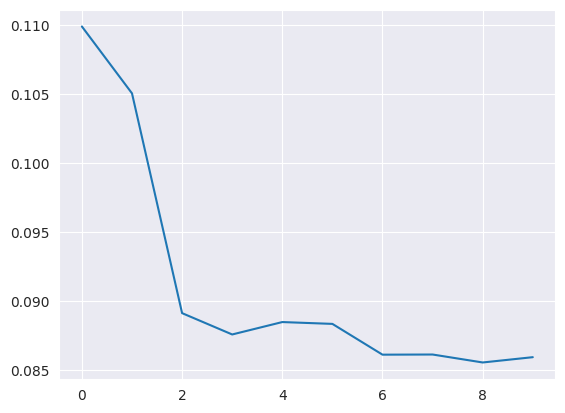

In [42]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from model.model import FlightNN
from model.scaler import Scaler

# Scale features and target
scaler_X = Scaler()
scaler_y = Scaler()

X_scaled = scaler_X.fit_transform(X_important)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=42)

# Create PyTorch Dataset
class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    # plot train loss
    plt.plot(train_losses, label='Train Loss')

# Set up training parameters
BATCH_SIZE = 1024
EPOCHS = 10
LEARNING_RATE = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets and dataloaders
train_dataset = FlightDataset(X_train, y_train)
test_dataset = FlightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model and training components
model = FlightNN(input_size=X_important.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train model
print("Training model...")
train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS, device)

In [43]:
# visualize model architecture
model

FlightNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [34]:
scaler_X.save('scaler_X.json')
scaler_y.save('scaler_y.json')

In [24]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

/tmp/ipykernel_984486/261288674.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


FlightNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [31]:
# Make predictions on test set
predictions = []
actuals = []
distance = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch).cpu().numpy()
        predictions.extend(pred)
        actuals.extend(y_batch.numpy())
        distance.extend(X_batch.cpu().numpy())


# Convert back to original scale
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).ravel()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).ravel()
distance = scaler_X.inverse_transform(np.array(distance))
print(distance.shape)
print(actuals.shape)

# Calculate metrics
mse = np.mean((predictions - actuals) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - actuals))
r2 = 1 - np.sum((actuals - predictions) ** 2) / np.sum((actuals - np.mean(actuals)) ** 2)

print("\nFinal Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")

# Save sample predictions
sample_results = pd.DataFrame({
    "Distance": distance[:100, 0],
    "Speed": distance[:100, 1],
    'Actual': actuals[:100],
    'Predicted': predictions[:100],
    'Error': np.abs(actuals[:100] - predictions[:100])
})

(214786, 2)
(214786,)

Final Metrics:
RMSE: 359.36
MAE: 227.13
R2 Score: 0.9218


In [32]:
sample_results

,Distance,Speed,Actual,Predicted,Error
0,11.800724,10.269561,516.000000,453.600861,62.399139
1,13.349293,257.777008,57.000019,120.713524,63.713505
2,232.274872,786.565186,1604.000000,1515.840210,88.159790
3,488.403046,946.830872,2432.000000,2384.249268,47.750732
4,588.510315,630.461853,4161.000000,3134.323242,1026.676758
...,...,...,...,...,...
95,414.640533,783.234558,1988.000000,2252.099854,264.099854
96,309.117218,453.119202,2616.000000,2111.282715,504.717285
97,148.938690,761.216614,1226.000000,1133.465576,92.534424
98,86.700539,425.713562,1359.000000,911.570374,447.429626
